# News Category Prediction

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict, Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [92]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [93]:
# Total number of unique categories
print("Unique categories:",df['category'].nunique())

Unique categories: 42


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [95]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Get the top 10 categories
top_10_categories = category_counts.head(10)

# Get the top 10 categories index
top_10_categories = category_counts.head(10).index

print(top_10_categories)

Index(['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY',
       'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK',
       'BUSINESS'],
      dtype='object', name='category')


In [96]:
# Load stopwords
stop_words = set(stopwords.words('english'))

# Define the text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Split into words
    words = text.split()
    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop_words]
    return cleaned_words

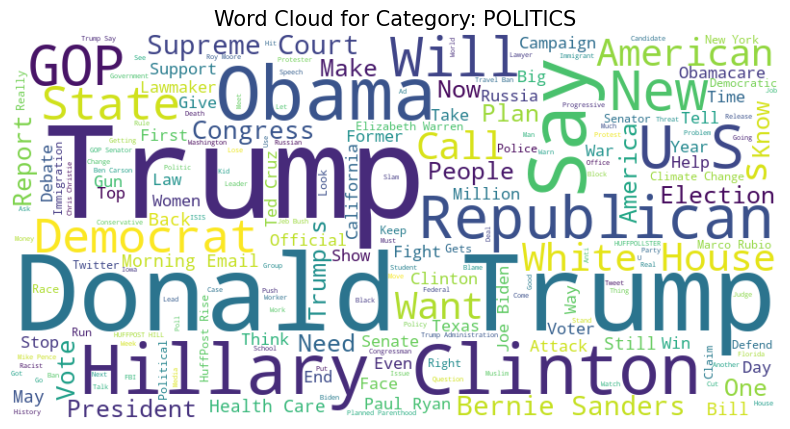

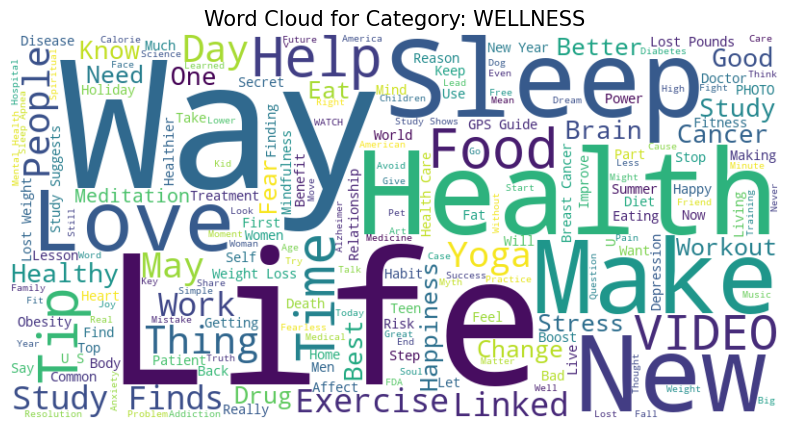

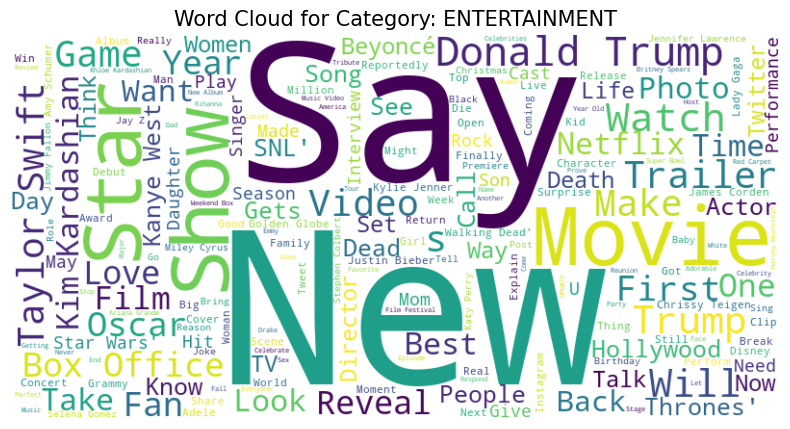

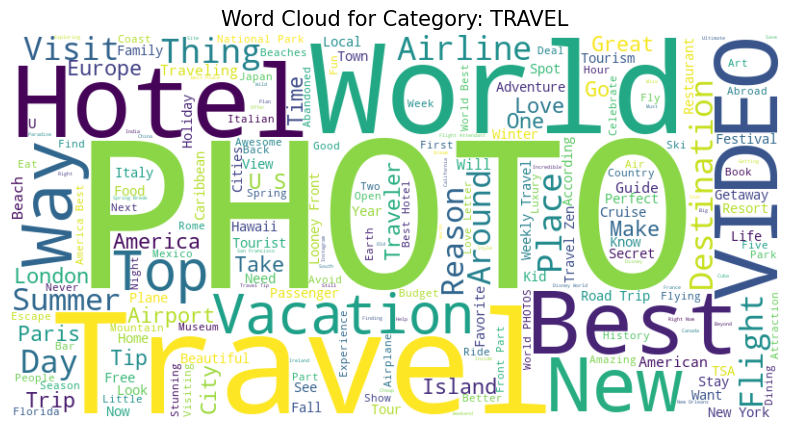

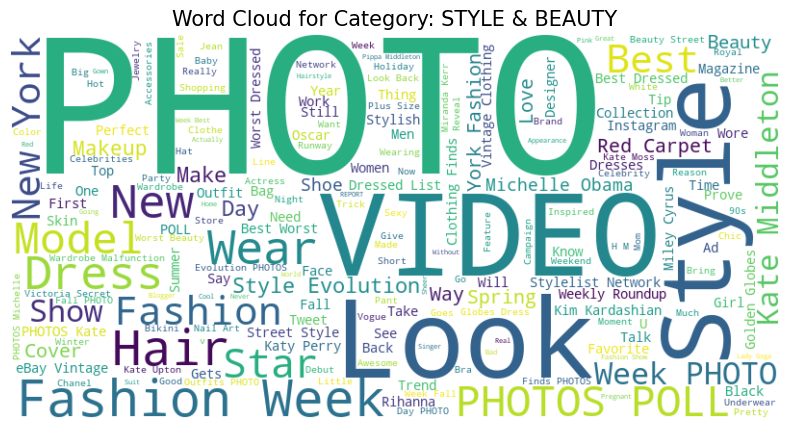

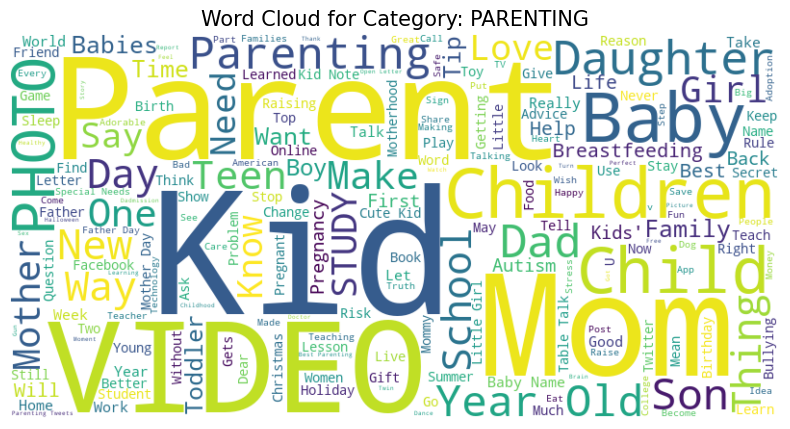

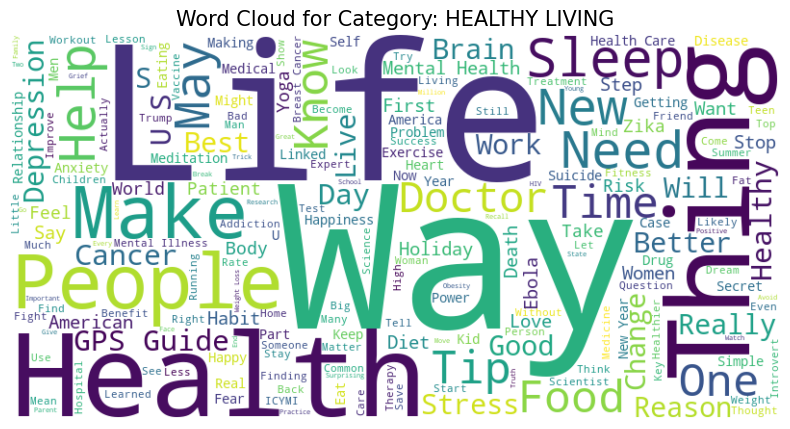

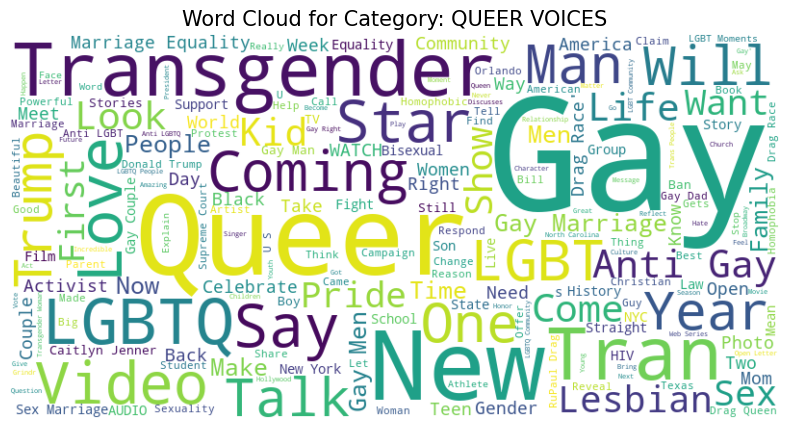

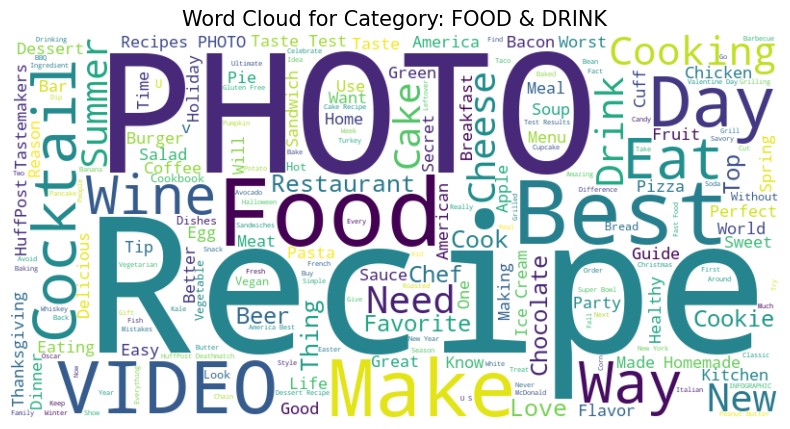

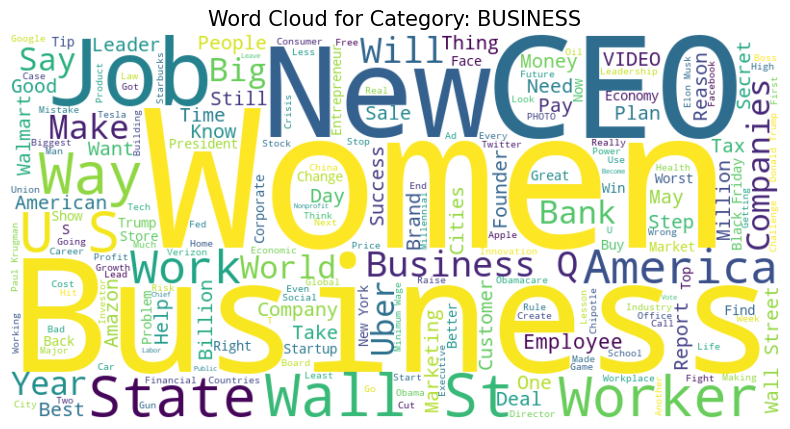

In [97]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

for category in top_10_categories:
    # Filter articles for the current category
    category_texts = df[df['category'] == category]['headline'].dropna()
    
    # Combine all texts into one
    combined_text = ' '.join(category_texts)
    cleaned_text = clean_text(combined_text)
    
    # Generate and display the word cloud
    generate_wordcloud(combined_text, f'Word Cloud for Category: {category}')

In [102]:
# Create a dictionary to store cleaned text for each category
category_dict = defaultdict(str)


categories = df['category'].unique()
# top_10_categories = category_counts.head(10).index
top_10_categories = category_counts.head().index

for category in top_10_categories:
    # Filter articles for the current category
    category_texts = df[df['category'] == category]['headline'].dropna()
    
    # Combine all texts into one
    combined_text = ' '.join(category_texts)
    
    # Clean the combined text
    cleaned_words = clean_text(combined_text)
    
    # Store the cleaned words in the dictionary
    category_dict[category] = cleaned_words

# Create a dictionary to store word frequencies for each category
word_frequencies = {}

for category, words in category_dict.items():
    word_count = Counter(words)
    word_frequencies[category] = word_count

# Print the dictionary to check
for category, frequencies in word_frequencies.items():
    print(f"Category: {category}")
    for word, count in frequencies.items():
        print(f"  {word}: {count}")
    print()  # Add a blank line for readability

In [118]:
# Create a dictionary to store the top 10 most frequent words for each category
top_10_words_dict = {}

for category, frequencies in word_frequencies.items():
    # Get the 10 most common words
    top_10_words = dict(frequencies.most_common(300))
    top_10_words_dict[category] = top_10_words

# Print the top 10 most frequent words for each category
for category, top_words in top_10_words_dict.items():
    print(f"Category: {category}")
    for word, count in top_words.items():
        print(f"  {word}: {count}")
    print()  # Add a blank line for readability

In [119]:
# Filter the DataFrame to keep only rows with top 10 categories
filtered_df = df[df['category'].isin(top_10_categories)]

# Check the result
print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (209527, 6)
Filtered DataFrame shape: (90623, 6)


In [120]:
# Define the function to predict category
def predict_category(headline, top_10_words_dict):
    # Clean the short description
    cleaned_description = clean_text(headline)
    description_word_count = Counter(cleaned_description)
    
    # Initialize variables to store best score and category
    best_score = -1
    best_category = None
    
    # Calculate the score for each category
    for category, top_words in top_10_words_dict.items():
        score = sum(description_word_count.get(word, 0) * count for word, count in top_words.items())
        if score > best_score:
            best_score = score
            best_category = category
    
    return best_category

# Apply the prediction function to each row
filtered_df['predicted_category'] = filtered_df['headline'].apply(lambda x: predict_category(x, top_10_words_dict))

# Compare with actual category
filtered_df['correct'] = filtered_df['category'] == filtered_df['predicted_category']

# Print the results
print(filtered_df[['headline', 'category', 'predicted_category', 'correct']].head())

# Calculate the accuracy
accuracy = filtered_df['correct'].mean()
print(f"Accuracy: {accuracy:.2f}")

# Calculate the error rate
num_incorrect_predictions = (filtered_df['correct'] == False).sum()
total_predictions = len(filtered_df)
error_rate = num_incorrect_predictions / total_predictions
print(f"Error Rate: {error_rate:.2f}")

                                             headline       category  \
20  Golden Globes Returning To NBC In January Afte...  ENTERTAINMENT   
21  Biden Says U.S. Forces Would Defend Taiwan If ...       POLITICS   
24  ‘Beautiful And Sad At The Same Time’: Ukrainia...       POLITICS   
28  James Cameron Says He 'Clashed' With Studio Be...  ENTERTAINMENT   
30  Biden Says Queen's Death Left 'Giant Hole' For...       POLITICS   

   predicted_category  correct  
20      ENTERTAINMENT     True  
21           POLITICS     True  
24           POLITICS     True  
28           POLITICS    False  
30           POLITICS     True  
Accuracy: 0.69
Error Rate: 0.31
